In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from src.data import compute_psi, compute_psi_for_features

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load and prepare data
df = pd.read_csv('../data/hour.csv')
df['dteday'] = pd.to_datetime(df['dteday'])

train_2011 = df[df['yr'] == 0].copy()
eval_2012 = df[df['yr'] == 1].copy()

feature_cols = [
    'season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
    'weathersit', 'temp', 'atemp', 'hum', 'windspeed'
]

X_train = train_2011[feature_cols]
y_train = train_2011['cnt']
X_test = eval_2012[feature_cols]
y_test = eval_2012['cnt']

# Train baseline
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=15, min_samples_split=5, random_state=42, n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred_baseline = rf_model.predict(X_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
print(f"Baseline RMSE: {baseline_rmse:.2f}")

Baseline RMSE: 125.66


## 1. Recreate All Experiment Scenarios

In [3]:
# Recreate all scenarios for unified analysis
scenarios = []

# Baseline (no drift)
psi_baseline = compute_psi_for_features(X_train, X_test, ['temp', 'atemp', 'hum', 'windspeed'])
scenarios.append({
    'name': 'Baseline (No Synthetic Drift)',
    'type': 'baseline',
    'psi_max': max(psi_baseline.values()),
    'rmse': baseline_rmse,
    'rmse_change': 0
})

# Experiment A: Humidity drift
for bias in [0.1, 0.2, 0.3]:
    X_drifted = X_test.copy()
    X_drifted['hum'] = (X_drifted['hum'] + bias).clip(0, 1)
    psi = compute_psi_for_features(X_train, X_drifted, ['hum'])
    y_pred = rf_model.predict(X_drifted)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scenarios.append({
        'name': f'A: Hum +{bias}',
        'type': 'data_drift',
        'psi_max': psi['hum'],
        'rmse': rmse,
        'rmse_change': rmse - baseline_rmse
    })

# Experiment B: Concept drift (morning rush changes)
morning_mask = eval_2012['hr'].isin([7, 8, 9])

# B1: Morning reduced by 50%
y_test_reduced = y_test.copy()
y_test_reduced.loc[morning_mask] = (y_test.loc[morning_mask] * 0.5).astype(int)
rmse_reduced = np.sqrt(mean_squared_error(y_test_reduced, y_pred_baseline))
scenarios.append({
    'name': 'B: Morning -50%',
    'type': 'concept_drift',
    'psi_max': max(psi_baseline.values()),
    'rmse': rmse_reduced,
    'rmse_change': rmse_reduced - baseline_rmse
})

# B2: Morning zeroed
y_test_zero = y_test.copy()
y_test_zero.loc[morning_mask] = 0
rmse_zero = np.sqrt(mean_squared_error(y_test_zero, y_pred_baseline))
scenarios.append({
    'name': 'B: Morning Zeroed',
    'type': 'concept_drift',
    'psi_max': max(psi_baseline.values()),
    'rmse': rmse_zero,
    'rmse_change': rmse_zero - baseline_rmse
})

# Experiment C: Low-importance feature noise
np.random.seed(42)
for noise_std in [0.2, 0.4, 0.5]:
    X_drifted = X_test.copy()
    X_drifted['windspeed'] = (X_drifted['windspeed'] + np.random.normal(0, noise_std, len(X_drifted))).clip(0, 1)
    psi = compute_psi_for_features(X_train, X_drifted, ['windspeed'])
    y_pred = rf_model.predict(X_drifted)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scenarios.append({
        'name': f'C: Wind σ={noise_std}',
        'type': 'low_importance_drift',
        'psi_max': psi['windspeed'],
        'rmse': rmse,
        'rmse_change': rmse - baseline_rmse
    })

scenarios_df = pd.DataFrame(scenarios)
print(scenarios_df.to_string(index=False))

                         name                 type  psi_max       rmse  rmse_change
Baseline (No Synthetic Drift)             baseline 0.048296 125.659877     0.000000
                  A: Hum +0.1           data_drift 0.168126 130.801550     5.141673
                  A: Hum +0.2           data_drift 0.928950 139.910513    14.250636
                  A: Hum +0.3           data_drift 3.666074 151.157472    25.497595
              B: Morning -50%        concept_drift 0.048296 111.922504   -13.737374
            B: Morning Zeroed        concept_drift 0.048296 137.247120    11.587243
                C: Wind σ=0.2 low_importance_drift 0.529285 127.456074     1.796197
                C: Wind σ=0.4 low_importance_drift 1.164577 128.993564     3.333686
                C: Wind σ=0.5 low_importance_drift 1.440062 129.922175     4.262297


## 2. Define Detection Thresholds

In [4]:
# Define thresholds
PSI_THRESHOLD = 0.1  # Standard PSI threshold for moderate drift
RMSE_THRESHOLD_PCT = 0.10  # 10% degradation from baseline
RMSE_THRESHOLD = baseline_rmse * (1 + RMSE_THRESHOLD_PCT)

print(f"Detection Thresholds:")
print(f"  PSI >= {PSI_THRESHOLD} triggers 'High PSI' alert")
print(f"  RMSE >= {RMSE_THRESHOLD:.2f} (+{RMSE_THRESHOLD_PCT*100:.0f}% from baseline {baseline_rmse:.2f}) triggers 'RMSE degraded' alert")

Detection Thresholds:
  PSI >= 0.1 triggers 'High PSI' alert
  RMSE >= 138.23 (+10% from baseline 125.66) triggers 'RMSE degraded' alert


In [5]:
# Classify each scenario into the 2x2 matrix
def classify_scenario(psi, rmse, psi_threshold, rmse_threshold):
    psi_high = psi >= psi_threshold
    rmse_high = rmse >= rmse_threshold
    
    if not psi_high and not rmse_high:
        return 'All Good', 'green'
    elif not psi_high and rmse_high:
        return 'False Negative (Concept Drift)', 'red'
    elif psi_high and not rmse_high:
        return 'False Positive', 'orange'
    else:
        return 'True Positive (Data Drift)', 'blue'

scenarios_df['classification'], scenarios_df['color'] = zip(*scenarios_df.apply(
    lambda row: classify_scenario(row['psi_max'], row['rmse'], PSI_THRESHOLD, RMSE_THRESHOLD),
    axis=1
))

print("\nScenario Classifications:")
print("="*70)
for _, row in scenarios_df.iterrows():
    print(f"{row['name']:<25} PSI={row['psi_max']:.3f}, RMSE={row['rmse']:.1f} -> {row['classification']}")


Scenario Classifications:
Baseline (No Synthetic Drift) PSI=0.048, RMSE=125.7 -> All Good
A: Hum +0.1               PSI=0.168, RMSE=130.8 -> False Positive
A: Hum +0.2               PSI=0.929, RMSE=139.9 -> True Positive (Data Drift)
A: Hum +0.3               PSI=3.666, RMSE=151.2 -> True Positive (Data Drift)
B: Morning -50%           PSI=0.048, RMSE=111.9 -> All Good
B: Morning Zeroed         PSI=0.048, RMSE=137.2 -> All Good
C: Wind σ=0.2             PSI=0.529, RMSE=127.5 -> False Positive
C: Wind σ=0.4             PSI=1.165, RMSE=129.0 -> False Positive
C: Wind σ=0.5             PSI=1.440, RMSE=129.9 -> False Positive


## 3. Visualize 2x2 Detection Matrix

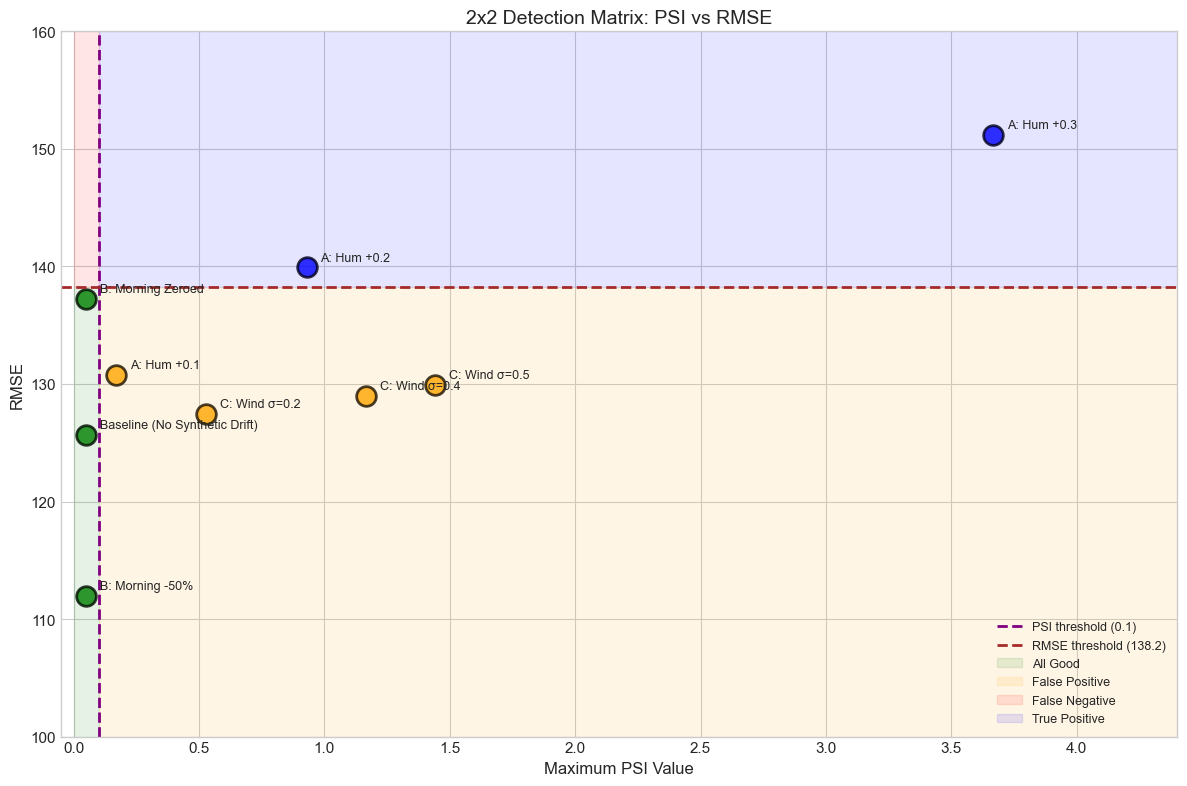

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot
for _, row in scenarios_df.iterrows():
    ax.scatter(row['psi_max'], row['rmse'], 
              c=row['color'], s=200, edgecolor='black', linewidth=2, alpha=0.8)
    ax.annotate(row['name'], (row['psi_max'], row['rmse']), 
               textcoords="offset points", xytext=(10, 5), fontsize=9)

# Draw threshold lines
ax.axvline(x=PSI_THRESHOLD, color='purple', linestyle='--', linewidth=2, label=f'PSI threshold ({PSI_THRESHOLD})')
ax.axhline(y=RMSE_THRESHOLD, color='brown', linestyle='--', linewidth=2, label=f'RMSE threshold ({RMSE_THRESHOLD:.1f})')

# Shade quadrants
ax.fill_between([0, PSI_THRESHOLD], 0, RMSE_THRESHOLD, alpha=0.1, color='green', label='All Good')
ax.fill_between([PSI_THRESHOLD, 5], 0, RMSE_THRESHOLD, alpha=0.1, color='orange', label='False Positive')
ax.fill_between([0, PSI_THRESHOLD], RMSE_THRESHOLD, 200, alpha=0.1, color='red', label='False Negative')
ax.fill_between([PSI_THRESHOLD, 5], RMSE_THRESHOLD, 200, alpha=0.1, color='blue', label='True Positive')

ax.set_xlabel('Maximum PSI Value', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('2x2 Detection Matrix: PSI vs RMSE', fontsize=14)
ax.legend(loc='lower right', fontsize=9)
ax.set_xlim(-0.05, max(scenarios_df['psi_max']) * 1.2)
ax.set_ylim(100, 160)

plt.tight_layout()
plt.show()

## 4. Count Classification Results

In [7]:
# Summary statistics
classification_counts = scenarios_df['classification'].value_counts()

print("\nClassification Summary:")
print("="*40)
for classification, count in classification_counts.items():
    print(f"  {classification}: {count}")

# Calculate detection rates
total = len(scenarios_df)
true_positives = (scenarios_df['classification'] == 'True Positive (Data Drift)').sum()
false_negatives = (scenarios_df['classification'] == 'False Negative (Concept Drift)').sum()
false_positives = (scenarios_df['classification'] == 'False Positive').sum()
all_good = (scenarios_df['classification'] == 'All Good').sum()

print(f"\n\nDetection Performance (PSI-only):")
print(f"  True Positives: {true_positives} / {total}")
print(f"  False Negatives (missed concept drift): {false_negatives} / {total}")
print(f"  False Positives (unnecessary alerts): {false_positives} / {total}")


Classification Summary:
  False Positive: 4
  All Good: 3
  True Positive (Data Drift): 2


Detection Performance (PSI-only):
  True Positives: 2 / 9
  False Negatives (missed concept drift): 0 / 9
  False Positives (unnecessary alerts): 4 / 9


## 5. Recommended Detection Strategy

In [8]:
print("="*70)
print("RECOMMENDED DETECTION STRATEGY")
print("="*70)
print("""
1. MONITOR BOTH PSI AND RMSE TOGETHER
   - PSI alone misses concept drift (feature distributions stable, target changes)
   - RMSE alone may be noisy without understanding root cause
   - Combined approach catches more failure modes

2. WEIGHT PSI BY FEATURE IMPORTANCE
   - High-importance features (hr, temp, atemp): weight PSI heavily
   - Low-importance features (holiday, windspeed): weight PSI lightly
   - Prevents false positives from irrelevant feature drift

3. USE SLIDING WINDOWS FOR RMSE
   - Daily/weekly RMSE comparisons catch sudden concept drift
   - Requires ground truth labels with some lag

4. ALERT THRESHOLDS:
   - PSI >= 0.1 on high-importance features: Investigate data pipeline
   - RMSE > 10% above baseline: Review model predictions
   - Both triggered: Likely real data drift, retrain model
   - Only RMSE triggered: Likely concept drift, collect new labels

5. MONITORING DASHBOARD:
   - Track PSI per feature over time
   - Track RMSE (if ground truth available) over time
   - Alert on threshold violations
""")

RECOMMENDED DETECTION STRATEGY

1. MONITOR BOTH PSI AND RMSE TOGETHER
   - PSI alone misses concept drift (feature distributions stable, target changes)
   - RMSE alone may be noisy without understanding root cause
   - Combined approach catches more failure modes

2. WEIGHT PSI BY FEATURE IMPORTANCE
   - High-importance features (hr, temp, atemp): weight PSI heavily
   - Low-importance features (holiday, windspeed): weight PSI lightly
   - Prevents false positives from irrelevant feature drift

3. USE SLIDING WINDOWS FOR RMSE
   - Daily/weekly RMSE comparisons catch sudden concept drift
   - Requires ground truth labels with some lag

4. ALERT THRESHOLDS:
   - PSI >= 0.1 on high-importance features: Investigate data pipeline
   - RMSE > 10% above baseline: Review model predictions
   - Both triggered: Likely real data drift, retrain model
   - Only RMSE triggered: Likely concept drift, collect new labels

5. MONITORING DASHBOARD:
   - Track PSI per feature over time
   - Track RMSE (i

In [9]:
# Create a weighted PSI approach
feature_importance = dict(zip(feature_cols, rf_model.feature_importances_))

def compute_weighted_psi(reference_df, current_df, importance_dict, features=None):
    """Compute PSI weighted by feature importance."""
    if features is None:
        features = ['temp', 'atemp', 'hum', 'windspeed']
    
    psi_values = compute_psi_for_features(reference_df, current_df, features)
    
    # Weight by importance
    total_importance = sum(importance_dict.get(f, 0) for f in features)
    weighted_psi = sum(
        psi_values[f] * (importance_dict.get(f, 0) / total_importance)
        for f in features
    )
    
    return weighted_psi, psi_values

# Test weighted PSI on Experiment C (should be lower)
print("Weighted PSI Demonstration:")
print("="*50)

# Experiment C with high noise
np.random.seed(42)
X_noisy = X_test.copy()
X_noisy['windspeed'] = (X_noisy['windspeed'] + np.random.normal(0, 0.5, len(X_noisy))).clip(0, 1)

unweighted_psi = compute_psi_for_features(X_train, X_noisy, ['temp', 'atemp', 'hum', 'windspeed'])
weighted_psi, _ = compute_weighted_psi(X_train, X_noisy, feature_importance)

print(f"\nExperiment C (windspeed noise σ=0.5):")
print(f"  Unweighted max PSI: {max(unweighted_psi.values()):.4f} (windspeed: {unweighted_psi['windspeed']:.4f})")
print(f"  Importance-weighted PSI: {weighted_psi:.4f}")
print(f"  Note: Weighted PSI is lower because windspeed has low importance ({feature_importance['windspeed']:.4f})")

Weighted PSI Demonstration:

Experiment C (windspeed noise σ=0.5):
  Unweighted max PSI: 1.4426 (windspeed: 1.4426)
  Importance-weighted PSI: 0.1113
  Note: Weighted PSI is lower because windspeed has low importance (0.0124)


## 6. Final Summary

In [12]:
print("="*70)
print("DRIFT DETECTION LEARNING PROJECT - FINAL SUMMARY")
print("="*70)

print("""
DATASET:
  UCI Bike Sharing (hourly) - 17,379 records
  Training: 2011 (8,645 records)
  Evaluation: 2012 (8,734 records)

MODEL:
  Random Forest Regressor (100 trees, max_depth=15)
  Baseline RMSE on 2012: ~126 (vs training RMSE ~20)
  Natural concept drift: 63% higher ridership in 2012 vs 2011

KEY FINDINGS:

1. NATURAL DRIFT EXISTS
   - Feature distributions (temp, hum, windspeed) are stable (PSI < 0.1)
   - Target distribution shifted significantly (+63% ridership)
   - This is CONCEPT DRIFT - same inputs, different outcomes

2. PSI DETECTION LIMITATIONS
   - ✓ WORKS: Data drift on important features (Exp A: hum bias)
   - ✗ FAILS: Concept drift without feature changes (Exp B: morning zeroed)
   - ✗ FAILS: Alerts on low-importance feature drift (Exp C: windspeed noise)

3. RECOMMENDED APPROACH
   - Monitor PSI weighted by feature importance
   - Monitor RMSE when ground truth available
   - Use 2x2 matrix to diagnose drift type
   - Combine multiple signals for robust detection

""")

print("Detection Matrix Summary:")
print("┌────────────────────┬────────────────────┬────────────────────┐")
print("│                    │ RMSE Stable        │ RMSE Degraded      │")
print("├────────────────────┼────────────────────┼────────────────────┤")
print("│ PSI Low            │ ✓ All Good         │ ⚡ Concept Drift    │")
print("│                    │ No action needed   │ Collect new labels │")
print("├────────────────────┼────────────────────┼────────────────────┤")
print("│ PSI High           │ ⚠️ False Positive  │ ✓ Data Drift      │")
print("│                    │ Check importance   │ Retrain model      │")
print("└────────────────────┴────────────────────┴────────────────────┘")

DRIFT DETECTION LEARNING PROJECT - FINAL SUMMARY

DATASET:
  UCI Bike Sharing (hourly) - 17,379 records
  Training: 2011 (8,645 records)
  Evaluation: 2012 (8,734 records)

MODEL:
  Random Forest Regressor (100 trees, max_depth=15)
  Baseline RMSE on 2012: ~126 (vs training RMSE ~20)
  Natural concept drift: 63% higher ridership in 2012 vs 2011

KEY FINDINGS:

1. NATURAL DRIFT EXISTS
   - Feature distributions (temp, hum, windspeed) are stable (PSI < 0.1)
   - Target distribution shifted significantly (+63% ridership)
   - This is CONCEPT DRIFT - same inputs, different outcomes

2. PSI DETECTION LIMITATIONS
   - ✓ WORKS: Data drift on important features (Exp A: hum bias)
   - ✗ FAILS: Concept drift without feature changes (Exp B: morning zeroed)
   - ✗ FAILS: Alerts on low-importance feature drift (Exp C: windspeed noise)

3. RECOMMENDED APPROACH
   - Monitor PSI weighted by feature importance
   - Monitor RMSE when ground truth available
   - Use 2x2 matrix to diagnose drift type
   -